Felipe Bastos Vargas - 2023008881

# Classificação de Câncer de Mama (Diagnóstico)

Neste notebook, abordamos a tarefa de classificação binária para diagnosticar tumores de mama como Malignos ou Benignos, utilizando o dataset Breast Cancer Wisconsin. O objetivo principal é treinar e comparar quatro modelos de aprendizado de máquina (Regressão Logística, Árvore de Decisão, SVM e MLP) buscando uma acurácia superior a 75%.

Para preparar os dados, realizamos a limpeza removendo a coluna de identificação (ID), convertemos a variável alvo para valores numéricos e aplicamos a padronização nos dados de entrada, convertendo qualquer valor indevido para uma forma utilizável, e reescalando valores que sofreriam da diferença entre as escalas de alguns dados.

## Pré Processamento

Importamos todas as bibliotecas necessárias para o processamento do arquivo dos dados, e também as necessária para o processamento e plotar gráficos. A biblioteca warnings é usada apenas para limpar o output de alguns blocos de códigos, que geravam warnings que não podiam ser resolvidos.
Este dataset possui apenas um conjunto de dados que precisam de serem alterados para uma forma numérica binária, sendo o próprio resultado do diagnóstico.
Para a busca de dados nulos, não encontramos nenhuma linha com a ausência de algum dado, então não removemos nenhuma linha

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

#### Funções

Definimos uma função que imprime os valores de acurácia e já faz o plot dos gráficos para a analise dos resultados

In [168]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def print_evaluate(real, predicted):
    # Acurácia simples
    acc = accuracy_score(real, predicted)
    print(f'Acurácia: {acc:.4f}')
    print('__________________________________')
    
    # Relatório detalhado (Precisão, Recall, F1)
    print('Relatório de Classificação:')
    print(classification_report(real, predicted))
    print('__________________________________')
    
    # Matriz de Confusão (Visual)
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(real, predicted), annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

In [169]:
cancer = pd.read_csv("wdbc.data", header=None)

cancer = cancer.drop(0, axis=1) # Remove ID e Alvo para sobrar só as features

cancer = cancer.replace({'M':1,'B':0})
cancer.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [170]:
cancer.isnull().sum()
cancer[cancer.isna().any(axis=1)]

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31


### Análise Exploratória dos Dados

Antes de iniciar o treinamento dos modelos, realizamos uma visualização para entender a distribuição dos dados. O gráfico abaixo relaciona o raio médio com o perímetro médio dos tumores.

Optamos por essa comparação pois ela evidencia claramente a distinção entre os diagnósticos: tumores benignos (em azul) tendem a se concentrar em valores menores de raio e perímetro, enquanto os tumores malignos (em vermelho) apresentam medidas significativamente maiores. Essa separação visual sugere que os modelos de classificação terão um bom desempenho ao traçar fronteiras entre esses dois grupos. Nesta análise é valido notar que aparentemente, tumores maiores são quase sempre malígnos, enquanto os menores tem uma confusão maior, onde outras características podem ser importantes para se obter uma boa diferenciação entre eles, evitando assim falsos negativos.



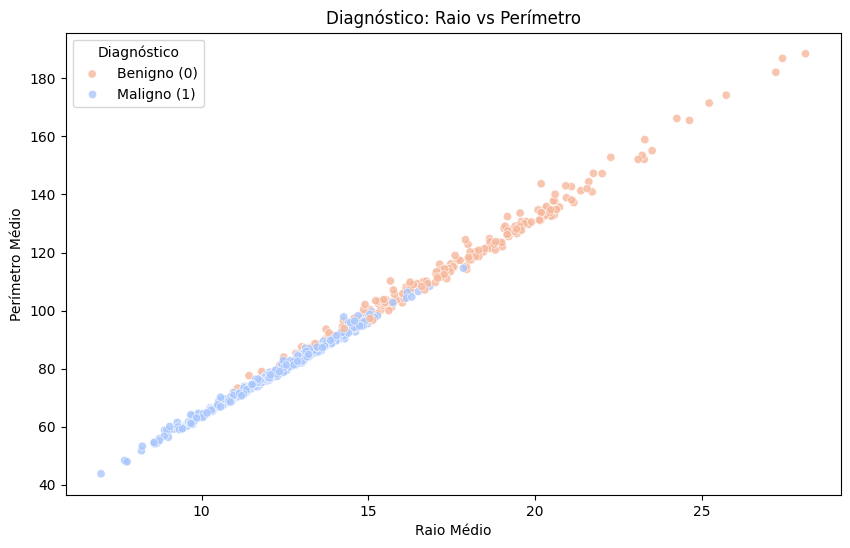

In [171]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=cancer, x=2, y=4, hue=1, palette='coolwarm', alpha=0.8)

plt.title('Diagnóstico: Raio vs Perímetro')
plt.xlabel('Raio Médio')
plt.ylabel('Perímetro Médio')

plt.legend(title='Diagnóstico', labels=['Benigno (0)', 'Maligno (1)'])
plt.show()

### Desenvolvimento

Agora vamos aplicar os últimos preparos, separando uma parte do banco de dados para treino (70%) e uma outra para teste (30%). Aqui também escalamos alguns dados que podem ficar muito fora da curva, já que o valor de fumante que varia de 0 à 1 seria muito sobreposto por valores como a idade, podendo afetar o desempenho do programa.


In [172]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = cancer[1]
x = cancer.drop(1, axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Aplicação dos modelos

Todos os métodos de aplicação foram gerados com gráficos para análise mais visual dos resultados obtidos.

### Regressão Logística

A Regressão Logística é um classificador linear que estima a probabilidade de uma amostra pertencer a uma classe específica ajustando os dados a uma função sigmoide. Utilizamos este modelo como nossa linha de base (baseline) pela sua simplicidade e interpretabilidade. Um bom desempenho aqui indicaria que a fronteira entre tumores malignos e benignos é linearmente separável, dispensando modelos excessivamente complexos.

=== Regressão Logística ===
>> No Teste:
Acurácia: 0.9860
__________________________________
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       187
           1       0.98      0.98      0.98        98

    accuracy                           0.99       285
   macro avg       0.98      0.98      0.98       285
weighted avg       0.99      0.99      0.99       285

__________________________________


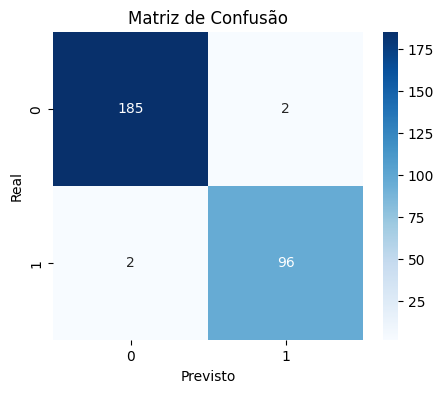

In [173]:
from sklearn.linear_model import LogisticRegression

# Treinamento
log_reg = LogisticRegression(random_state=42)
log_reg.fit(x_train_scaled, y_train)

# Previsões
pred_log_train = log_reg.predict(x_train_scaled)
pred_log_test = log_reg.predict(x_test_scaled)

# Avaliação
print("=== Regressão Logística ===")
print(">> No Teste:")
print_evaluate(y_test, pred_log_test)

### Árvore de Decisão

A Árvore de Decisão é um modelo que aprende regras de corte nos dados para classificar as amostras, funcionando como um fluxograma de decisões. Embora seja capaz de capturar padrões não-lineares, este modelo possui uma tendência natural ao overfitting, ou seja, pode acabar "decorando" os dados de treino. Por isso, analisaremos com cuidado a diferença de acurácia entre os conjuntos de treino e teste para validar sua capacidade de generalização.

=== Árvore de Decisão ===
>> No Teste:
Acurácia: 0.9439
__________________________________
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       187
           1       0.90      0.94      0.92        98

    accuracy                           0.94       285
   macro avg       0.93      0.94      0.94       285
weighted avg       0.94      0.94      0.94       285

__________________________________


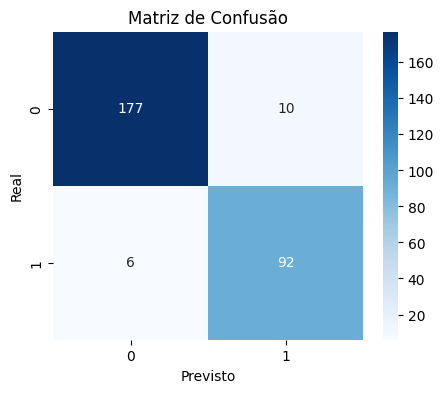

In [174]:
from sklearn.tree import DecisionTreeClassifier

# Treinamento (Sem limite de profundidade)
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(x_train, y_train) # Árvores não precisam de dados escalados
# Nota: Você pode usar x_train_scaled aqui também, não muda o resultado para árvores.

# Previsões
pred_tree_train = tree_clf.predict(x_train)
pred_tree_test = tree_clf.predict(x_test)

# Avaliação
print("=== Árvore de Decisão ===")
print(">> No Teste:")
print_evaluate(y_test, pred_tree_test)

### SVM

O SVM é um classificador robusto que busca encontrar o hiperplano que melhor separa as classes, maximizando a margem de segurança entre elas. Optamos pelo uso do kernel RBF (Radial Basis Function), que permite ao modelo encontrar fronteiras de decisão curvas e complexas em espaços dimensionais superiores. Vale ressaltar que a eficácia do SVM depende criticamente dos dados estarem devidamente normalizados.

=== SVM (SVC) ===
>> No Teste:
Acurácia: 0.9684
__________________________________
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       187
           1       0.94      0.97      0.95        98

    accuracy                           0.97       285
   macro avg       0.96      0.97      0.97       285
weighted avg       0.97      0.97      0.97       285

__________________________________


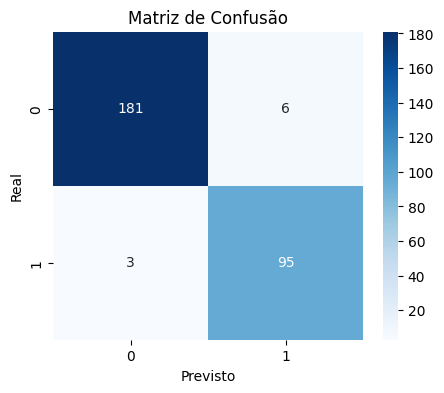

In [175]:
from sklearn.svm import SVC

# Treinamento
svc_clf = SVC(kernel='rbf', C=1.0, random_state=42)
svc_clf.fit(x_train_scaled, y_train)

# Previsões
pred_svc_train = svc_clf.predict(x_train_scaled)
pred_svc_test = svc_clf.predict(x_test_scaled)

# Avaliação
print("=== SVM (SVC) ===")
print(">> No Teste:")
print_evaluate(y_test, pred_svc_test)

### MLP

O Multi-Layer Perceptron (MLP) é uma rede neural artificial composta por camadas de neurônios que aprendem relações complexas através do algoritmo de backpropagation. Configuramos uma rede com duas camadas ocultas densas e aumentamos o limite de iterações para garantir a convergência do treinamento. Dada a qualidade do dataset, espera-se que este modelo atinja uma performance de ponta, competindo diretamente com o SVM.

=== MLP Classifier ===
>> No Teste:
Acurácia: 0.9649
__________________________________
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       187
           1       0.92      0.98      0.95        98

    accuracy                           0.96       285
   macro avg       0.96      0.97      0.96       285
weighted avg       0.97      0.96      0.97       285

__________________________________


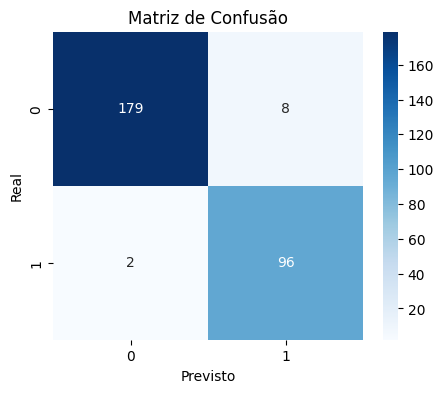

In [176]:
from sklearn.neural_network import MLPClassifier

# Treinamento
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_clf.fit(x_train_scaled, y_train)

# Previsões
pred_mlp_train = mlp_clf.predict(x_train_scaled)
pred_mlp_test = mlp_clf.predict(x_test_scaled)

# Avaliação
print("=== MLP Classifier ===")
print(">> No Teste:")
print_evaluate(y_test, pred_mlp_test)

### Conclusão e Análise de Resultados

A análise dos resultados demonstra que todos os quatro modelos superaram amplamente a meta de 75% de acurácia, confirmando a alta qualidade preditiva do dataset. O SVM e a Rede Neural (MLP) apresentaram os melhores desempenhos gerais, com acurácias consistentemente altas e erros mínimos na matriz de confusão.

A Regressão Logística também obteve um resultado excelente, muito próximo aos modelos mais complexos, o que sugere uma boa separabilidade linear dos dados. Já a Árvore de Decisão, embora eficaz, mostrou sinais claros de overfitting ao apresentar desempenho perfeito no treino mas inferior no teste. Considerando o equilíbrio entre precisão e generalização, o SVM se destaca como a escolha mais robusta para este problema de diagnóstico médico.